888
  samples  obs_total_draws  mean_total_draws  median_total_draws  std_total_draws  percentile_rank_of_obs_%
100000000              888           550.934               551.0           99.545                     0.018


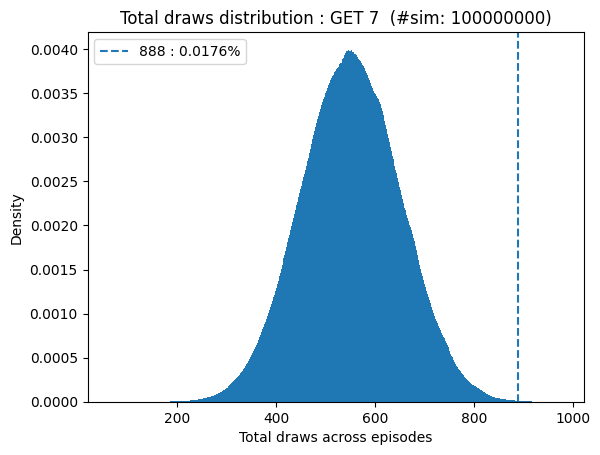

In [16]:
# -*- coding: utf-8 -*-
"""
Fast Monte Carlo for total draws across episodes (vectorized, no filter).
- Odd-episode coin requirement is independent of T; removing coin/filter keeps the same distribution of total draws.
- Uses inverse CDF sampling with tail normalization for safety.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

draws = [65, 68, 65, 69, 65, 70, 62, 49, 47, 58, 69, 63, 69, 69]
print(sum(draws))
# =========================
# Config
# =========================
GAME_ID = 1
GOAL = 7               # 뽑은 "진짜 당첨" 개수
OBS_TOTAL = 888        # 관측된 총 뽑기 수

N_SIMS = 100_000_000    # 몬테카를로 샘플 수
SEED = 20251014        # 재현성
BINS = 910             # 구간의 등분 수 (많을 수록 구간 작아짐)

if GAME_ID == 1:
    CEIL_RATIO = 0.5       # 당첨시 "진짜"일 확률
    MAX_T = 80             # pity 스케줄 상한 (1..80)
    BASE_P = 0.008         # t<=63 구간 성공확률
    ACCEL_START = 63       # 가속 시작 시점(포함)
    ACCEL_STEP = 0.06      # t>63부터 증가폭

elif GAME_ID == 2:
    CEIL_RATIO = 0.55      # 당첨시 "진짜"일 확률
    MAX_T = 90             # pity 스케줄 상한 (1..80)
    BASE_P = 0.006         # t<=63 구간 성공확률
    ACCEL_START = 73       # 가속 시작 시점(포함)
    ACCEL_STEP = 0.06      # t>73부터 증가폭


# PRINT_OTHER_GRAPHS = True

# =========================
# Build pity pmf/cdf (with tail normalization)
# =========================
def build_pity_cdf(max_t=MAX_T, base_p=BASE_P, accel_start=ACCEL_START, accel_step=ACCEL_STEP):
    """
    Returns:
        cdf: shape (max_t,), cumulative distribution of T in {1..max_t}
    """
    p = np.empty(max_t, dtype=float)
    for t in range(1, max_t + 1):
        if t <= accel_start:
            p[t-1] = base_p
        else:
            p[t-1] = min(base_p + accel_step * (t - accel_start), 1.0)

    pmf = np.empty(max_t, dtype=float)
    survival = 1.0
    for i in range(max_t):
        pmf[i] = survival * p[i]
        survival *= (1.0 - p[i])

    # 마지막 구간에 꼬리 확률(미성공 잔여)을 더해 정규화
    cdf = np.cumsum(pmf)
    tail = 1.0 - cdf[-1]
    if tail > 0:
        pmf[-1] += tail
        cdf = np.cumsum(pmf)

    # if PRINT_OTHER_GRAPHS:
    #     pmf = np.diff(np.r_[0, cdf])  # 각 시도별 최초 성공 확률
    #     t = np.arange(1, len(cdf) + 1)

    #     plt.figure(figsize=(8,4))
    #     plt.plot(t, cdf, label='CDF (P(T ≤ t))')
    #     plt.bar(t, pmf, alpha=0.3, label='PMF (P(T = t))')
    #     plt.xlabel("t (draw count until success)")
    #     plt.ylabel("Probability")
    #     plt.title("Pity distribution (CDF & PMF)")
    #     plt.legend()
    #     plt.grid(True, alpha=0.3)
    #     plt.show()

    # 수치적으로 1.0이 아닐 수 있어도, searchsorted에는 충분함
    return cdf


def sample_T_matrix(n_sims, base_episodes, cdf, p=CEIL_RATIO, seed=None):
    """
    각 시뮬레이션마다 50% 확률 7회 뽑기 결과에 따라 episodes 수를 동적으로 결정한 뒤,
    각자에 대해 T 샘플을 생성합니다.
    
    Args:
        n_sims (int): 시뮬레이션 횟수
        base_episodes (int): 기본 episode 수 (예: 7) 즉, 뽑고 싶은 '실제 당첨' 회수
        cdf (np.ndarray): pity CDF
        p (float): 50% 확률 뽑기의 성공 확률 (기본값 0.5)
        seed (int, optional): 난수 시드
    
    Returns:
        np.ndarray: shape (n_sims, variable), 
                    padding 포함된 샘플 행렬 (최대 episode 수 기준)
        np.ndarray: 각 시뮬레이션별 실제 episode 수
    """
    rng = np.random.default_rng(seed)
    
    # --- 각 시뮬레이션별 동적 episode 결정 ---
    # 7번의 50% 확률 시도 → 성공할 때마다 episode +1
    add_episodes = rng.binomial(n=7, p=p, size=n_sims)
    episodes_each = base_episodes + add_episodes

    # if PRINT_OTHER_GRAPHS:
    #     nums = np.arange(7, 15)
    #     counts = np.array([(episodes_each == v).sum() for v in nums])
    #     plt.figure()
    #     plt.bar(nums, counts)
    #     plt.title(f"How many ceiling did you arrived while get {GOAL}")
    #     plt.xlabel("Total ceiling")
    #     plt.ylabel("Count")
    #     plt.show()

    # --- 결과 저장용 행렬 (패딩 포함) ---
    totals = np.empty(n_sims, dtype=np.int64)

    unique_ep = np.unique(episodes_each)
    for k in unique_ep:
        idx = np.where(episodes_each == k)[0]
        if k == 0:
            totals[idx] = 0
            continue

        # (그룹 크기 m) × (에피소드 수 k) 한꺼번에 샘플링
        U = rng.random((idx.size, k), dtype=np.float32)
        # inverse-CDF
        T_block = np.searchsorted(cdf, U, side="left") + 1  # shape: (m, k), int
        # 행별 합
        totals[idx] = T_block.sum(axis=1, dtype=np.int64)

    return totals

# =========================
# Simulation + summary
# =========================
def simulate_and_summarize(n_sims=N_SIMS, goal=GOAL, obs_total=OBS_TOTAL, seed=SEED,
                           plot_hist=True, bins=BINS):
    cdf = build_pity_cdf()
    totals = sample_T_matrix(n_sims, goal, cdf, seed=seed)
    # totals = T.sum(axis=1)

    # 퍼센타일(<= obs_total 비율)
    percentile = float((totals > obs_total).mean() * 100.0)

    summary = {
        "samples": int(n_sims),
        "obs_total_draws": int(obs_total),
        "mean_total_draws": float(totals.mean()),
        "median_total_draws": float(np.median(totals)),
        "std_total_draws": float(totals.std(ddof=1)),
        "percentile_rank_of_obs_%": percentile,
    }

    # 출력
    df = pd.DataFrame([summary])
    print(df.round(3).to_string(index=False))

    # 히스토그램(선택)
    if plot_hist:
        plt.figure()
        plt.hist(totals, bins=bins, density=True)
        plt.axvline(obs_total, linestyle="--", label=f"{obs_total} : {percentile:.4f}%")
        plt.title(f"Total draws distribution : GET {goal}  (#sim: {n_sims})")
        plt.xlabel("Total draws across episodes")
        plt.ylabel("Density")
        plt.legend()
        plt.show()

    return totals, summary

def get_percentage(totals, obs_total):
    return float((totals > obs_total).mean() * 100.0)

# =========================
# Main
# =========================
if __name__ == "__main__":
    # 성능 팁(옵션): 과다 스레딩 방지
    # import os
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
    # os.environ["OPENBLAS_NUM_THREADS"] = "1"

    totals, summary = simulate_and_summarize(
        n_sims=N_SIMS,
        goal=GOAL,
        obs_total=OBS_TOTAL,
        seed=SEED,
        plot_hist=True,
        bins=BINS,
    )


In [54]:
int(max(totals)*0.935)

911

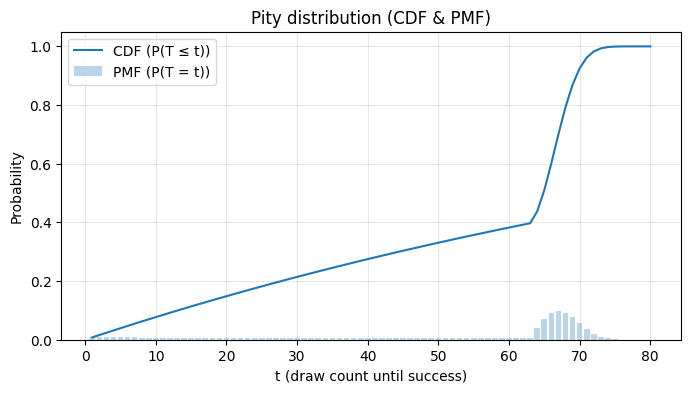

52.46918788590601 484.78049167836303


In [37]:
cdf = build_pity_cdf()
pmf = np.diff(np.r_[0, cdf])
E_T = (np.arange(1, len(pmf)+1) * pmf).sum()
Var_T = ((np.arange(1, len(pmf)+1) - E_T)**2 * pmf).sum()
print(E_T, Var_T)


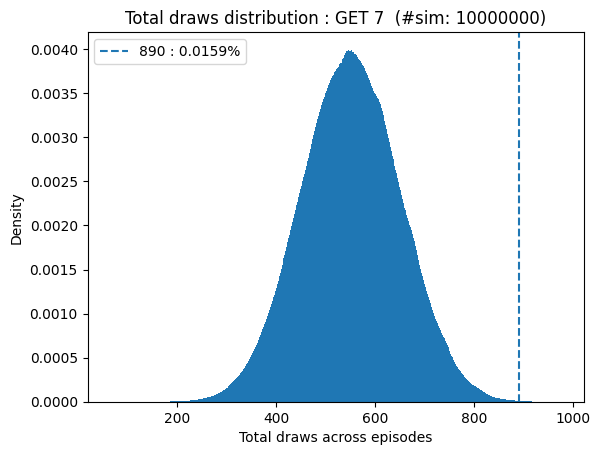

In [59]:
def get_percentage(totals, obs_total):
    return float((totals > obs_total).mean() * 100.0)

goal = 7
n_sims = N_SIMS
obs = 890
percentile = get_percentage(totals, obs)

plt.figure()
plt.hist(totals, bins=910, density=True)
plt.axvline(obs, linestyle="--", label=f"{obs} : {percentile:.4f}%")
plt.title(f"Total draws distribution : GET {goal}  (#sim: {n_sims})")
plt.xlabel("Total draws across episodes")
plt.ylabel("Density")
plt.legend()
plt.show()

In [17]:
from collections import Counter
import math
import numpy as np

# ===============================
# 1) 단일 에피소드 T의 pmf (가속 해저드 + 유한 상한)
# ===============================
def build_pity_pmf(BASE_P: float, ACCEL_START: int, ACCEL_STEP: float, MAX_T: int):
    """
    반환: pmf_T (numpy 1D, 인덱스가 '시도 수'와 일치; index 0은 항상 0)
    지원: t = 1..MAX_T,   마지막 칸에 남은 꼬리를 몰아넣음
    """
    assert 0 < BASE_P < 1
    assert 1 <= ACCEL_START <= MAX_T
    assert ACCEL_STEP >= 0
    # 성공확률 p_t
    p = np.zeros(MAX_T, dtype=np.float64)
    for t in range(1, MAX_T + 1):
        if t <= ACCEL_START:
            p[t - 1] = BASE_P
        else:
            inc = BASE_P + ACCEL_STEP * (t - ACCEL_START)
            p[t - 1] = 1.0 if inc >= 1.0 else inc

    # pmf_T[t] = P(T=t), survival 곱으로 구성
    pmf_T = np.zeros(MAX_T + 1, dtype=np.float64)  # index = t
    survival = 1.0
    for i in range(MAX_T - 1):  # 1..MAX_T-1
        pt = p[i]
        pmf_T[i + 1] = survival * pt
        survival *= (1.0 - pt)

    # 꼬리 이월(마지막 칸)
    pmf_T[MAX_T] = 1.0 - pmf_T.sum()
    # 수치 보정
    if pmf_T[MAX_T] < 0:
        pmf_T[MAX_T] = 0.0
        pmf_T /= pmf_T.sum()
    return pmf_T  # length = MAX_T+1 (index 0 unused)


# ===============================
# 2) FFT 기반 이산 pmf 거듭제곱(컨볼루션)
# ===============================
def _next_pow2(n):
    return 1 << (n - 1).bit_length()

def pmf_power_fft(pmf: np.ndarray, k: int) -> np.ndarray:
    """
    pmf의 k회 컨볼루션 결과 (이산 합의 pmf)
    pmf는 index = 값(0,1,2,...)에 대응. 여기서는 pmf_T[0]=0, pmf_T[1..MAX_T]>0.
    """
    assert k >= 1
    # 지지 길이: len(pmf) = L  (T의 최소가 1이라 S 최소 = k)
    base = pmf.copy()
    res = np.array([1.0], dtype=np.float64)  # delta_0

    def conv(a, b):
        la, lb = len(a), len(b)
        n = _next_pow2(la + lb - 1)
        fa = np.fft.rfft(a, n)
        fb = np.fft.rfft(b, n)
        c = np.fft.irfft(fa * fb, n)[: la + lb - 1]
        # 음수 미세 오차 제거
        c[c < 0] = 0.0
        s = c.sum()
        if s > 0:
            c /= s
        return c

    # 거듭제곱 (분할정복)
    k_bin = k
    cur = base
    while k_bin > 0:
        if k_bin & 1:
            res = conv(res, cur)
        k_bin >>= 1
        if k_bin:
            cur = conv(cur, cur)
    # 정규화
    sres = res.sum()
    if sres > 0:
        res /= sres
    return res


# ===============================
# 3) 무작위 합 S의 pmf (goal + Binomial(7, r))
# ===============================
def compound_pmf_S(pmf_T: np.ndarray, goal: int, r: float) -> np.ndarray:
    """
    pmf_T: 단일 에피소드 T의 pmf (index = t; length MAX_T+1, pmf_T[0]=0)
    goal: 고정 에피소드 수 (양의 정수)
    r:   추가 7회 중 성공 확률 (0 < r < 1), K = goal + Binom(7,r)

    반환: pmf_S (index = 총 뽑기 수)
    """
    assert goal >= 1
    assert 0.0 < r < 1.0

    # Binomial(7, r) 혼합
    # 각 k = goal+b 에 대해 pmf_T의 k-회 컨볼루션을 만들고 가중합
    # 지지 길이 상한: S 최대 ≈ (goal+7) * MAX_T
    MAX_T = len(pmf_T) - 1
    max_k = goal + 7
    # 누적할 pmf_S
    pmf_S = np.zeros(max_k * MAX_T + 1, dtype=np.float64)  # 넉넉히 잡고 합산 후 트림

    from math import comb
    for b in range(0, 8):  # 0..7
        weight = comb(7, b) * (r ** b) * ((1 - r) ** (7 - b))
        k = goal + b
        pk = pmf_power_fft(pmf_T, k)  # index = 합 (최소 k, 최대 k*MAX_T)
        # pk의 길이가 k*MAX_T+1일 것. pmf_S에 길이 맞춰 더함
        pmf_S[: len(pk)] += weight * pk

    # 정규화 및 뒤쪽 0 트림
    s = pmf_S.sum()
    if s > 0:
        pmf_S /= s

    # 불필요한 꼬리 0 제거(선택)
    last = len(pmf_S) - 1
    while last > 0 and pmf_S[last] == 0.0:
        last -= 1
    pmf_S = pmf_S[: last + 1]
    return pmf_S


# ===============================
# 4) 로그우도 (카운트 묶어 계산)
# ===============================
def loglikelihood(pmf: np.ndarray, data: list[int]) -> float:
    # 데이터 값이 pmf 길이 밖이면 아주 작은 확률로 취급
    cnt = Counter(data)
    ll = 0.0
    eps = 1e-300
    L = len(pmf)
    for x, c in cnt.items():
        p = pmf[x] if 0 <= x < L else 0.0
        ll += c * math.log(p + eps)
    return ll


# ===============================
# 5) 간단 피팅 (격자탐색) — BASE_P, ACCEL_STEP, r
#    (ACCEL_START, MAX_T, goal은 인자로 고정)
# ===============================
def fit_model(DATA: list[int],
              goal: int,
              ACCEL_START: int,
              MAX_T: int,
              base_p_grid=(0.003, 0.004, 0.005, 0.006, 0.007, 0.008),
              accel_step_grid=(0.03, 0.04, 0.05, 0.06, 0.07),
              r_grid=(0.45, 0.50, 0.55, 0.60)) -> dict:
    """
    반환: dict(params=..., pmf_S=..., ll=..., mu=..., sigma=...)
    - 격자 해상도는 필요에 따라 늘리세요(시간-정밀도 트레이드오프).
    """
    best = {"ll": -1e300}
    DATA_arr = np.asarray(DATA, dtype=np.int64)

    for BASE_P in base_p_grid:
        for ACCEL_STEP in accel_step_grid:
            pmf_T = build_pity_pmf(BASE_P, ACCEL_START, ACCEL_STEP, MAX_T)
            for r in r_grid:
                pmf_S = compound_pmf_S(pmf_T, goal, r)
                ll = loglikelihood(pmf_S, DATA_arr)
                if ll > best["ll"]:
                    # 요약 통계
                    xs = np.arange(len(pmf_S))
                    mu = float((xs * pmf_S).sum())
                    sigma = float(np.sqrt(((xs - mu) ** 2 * pmf_S).sum()))
                    best = {
                        "ll": ll,
                        "params": {
                            "BASE_P": BASE_P,
                            "ACCEL_START": ACCEL_START,
                            "ACCEL_STEP": ACCEL_STEP,
                            "MAX_T": MAX_T,
                            "goal": goal,
                            "r": r,
                        },
                        "pmf_S": pmf_S,
                        "mu": mu,
                        "sigma": sigma,
                    }
    return best


# ===============================
# 6) 상위 퍼센트 계산 (모델/경험적)
# ===============================
def upper_percent_model(pmf_S: np.ndarray, x: int) -> float:
    """
    모델 pmf 기준 상위 비율(%): P(S > x) * 100
    """
    L = len(pmf_S)
    if x + 1 < L:
        tail = pmf_S[x + 1 :].sum()
    else:
        tail = 0.0
    return float(tail * 100.0)

def upper_percent_empirical(DATA: list[int], x: int) -> float:
    """
    경험적(ECDF) 상위 비율(%): (# {s_i > x}) / n * 100
    """
    n = len(DATA)
    if n == 0:
        return float("nan")
    greater = sum(1 for v in DATA if v > x)
    return float(greater * 100.0 / n)


# ===============================
# 7) 사용 예시
# ===============================
if __name__ == "__main__":
    # 예시: DATA가 주어졌다고 가정
    # DATA = [...]  # 총 뽑기 횟수 리스트(정수)

    rng = 900
    DATA = totals

    # 도메인 지식에 맞춰 고정 (필요시 조정)
    GOAL = 7
    ACCEL_START = 63   # 게임1 예시값
    MAX_T = 80         # 게임1 예시값

    fit = fit_model(DATA, goal=GOAL, ACCEL_START=ACCEL_START, MAX_T=MAX_T)
    params = fit["params"]
    pmf_S = fit["pmf_S"]

    print("== Fitted Params ==")
    for k, v in params.items():
        print(f"{k}: {v}")
    print(f"LogLik: {fit['ll']:.2f}, mean≈{fit['mu']:.4f}, std≈{fit['sigma']:.4f}")

    # 특정 x의 상위 퍼센트 (모델/경험적)
    x = 888
    up_model = upper_percent_model(pmf_S, x)
    up_emp = upper_percent_empirical(DATA, x)
    print(f"x={x} 모델 상위 비율 ≈ {up_model:.6f}%")
    print(f"x={x} 경험적 상위 비율 ≈ {up_emp:.6f}%")


== Fitted Params ==
BASE_P: 0.008
ACCEL_START: 63
ACCEL_STEP: 0.06
MAX_T: 80
goal: 7
r: 0.5
LogLik: -601919532.95, mean≈550.9265, std≈99.5388
x=888 모델 상위 비율 ≈ 0.017570%
x=888 경험적 상위 비율 ≈ 0.017614%


Episode 고정 = 14
샘플 수 = 10,000,000
관측값 obs_total = 888
Mean = 734.621, Median = 739.000, Std = 82.375
P(Total ≤ 888) = 2.073%
FINAL P = 0.016%


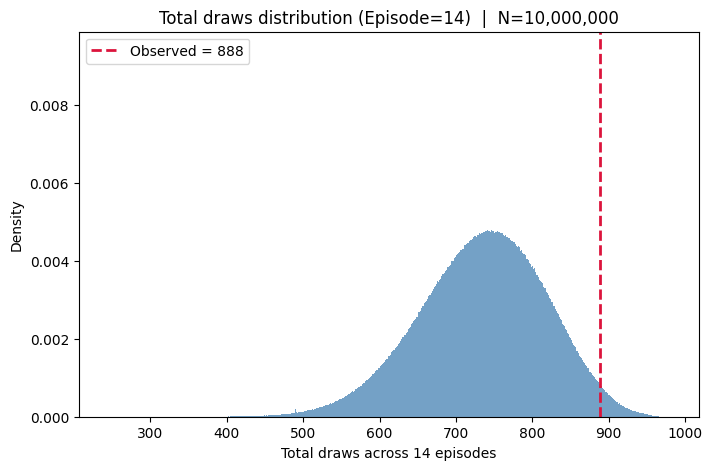

In [56]:
"""
Episode=14 고정 상태에서 obs_total=888 분포와 확률 시각화
"""

import numpy as np
import matplotlib.pyplot as plt

# ===== Config =====
MAX_T = 80
BASE_P = 0.008
ACCEL_START = 63
ACCEL_STEP = 0.06
GOALS  = 7
EPISODES = GOALS*2
N_SIMS = 10_000_000
OBS_TOTAL = 888
SEED = 20251014


def build_pity_cdf(max_t=MAX_T, base_p=BASE_P, accel_start=ACCEL_START, accel_step=ACCEL_STEP):
    """각 뽑기 T의 누적분포 (CDF) 생성"""
    p = np.empty(max_t, dtype=float)
    for t in range(1, max_t + 1):
        p[t-1] = base_p if t <= accel_start else min(base_p + accel_step * (t - accel_start), 1.0)
    pmf = np.empty(max_t, dtype=float)
    survival = 1.0
    for i in range(max_t):
        pmf[i] = survival * p[i]
        survival *= (1 - p[i])
    cdf = np.cumsum(pmf)
    tail = 1 - cdf[-1]
    if tail > 0:
        pmf[-1] += tail
        cdf = np.cumsum(pmf)
    return cdf


def simulate_fixed_episode(n_sims=N_SIMS, episodes=EPISODES, obs_total=OBS_TOTAL, seed=SEED):
    """episode=14 고정 시 총 뽑기 분포 계산"""
    cdf = build_pity_cdf()
    rng = np.random.default_rng(seed)

    # 각 episode마다 1개의 T를 역CDF로 샘플링
    U = rng.random((n_sims, episodes))
    T = np.searchsorted(cdf, U, side="left") + 1
    totals = T.sum(axis=1)

    # 확률 계산
    percentile = float((totals > obs_total).mean() * 100.0)
    _ratio = (1/2)**GOAL
    final_p = percentile*_ratio


    print(f"Episode 고정 = {episodes}")
    print(f"샘플 수 = {n_sims:,}")
    print(f"관측값 obs_total = {obs_total}")
    print(f"Mean = {totals.mean():.3f}, Median = {np.median(totals):.3f}, Std = {totals.std(ddof=1):.3f}")
    print(f"P(Total ≤ {obs_total}) = {percentile:.3f}%")
    print(f"FINAL P = {final_p:.3f}%")

    # 시각화
    plt.figure(figsize=(8,5))
    plt.hist(totals, bins=735, density=True, color="steelblue", alpha=0.75)
    plt.axvline(obs_total, color="crimson", linestyle="--", linewidth=2, label=f"Observed = {obs_total}")
    plt.title(f"Total draws distribution (Episode=14)  |  N={n_sims:,}")
    plt.xlabel("Total draws across 14 episodes")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    return totals, percentile


if __name__ == "__main__":
    simulate_fixed_episode()


# Other trials

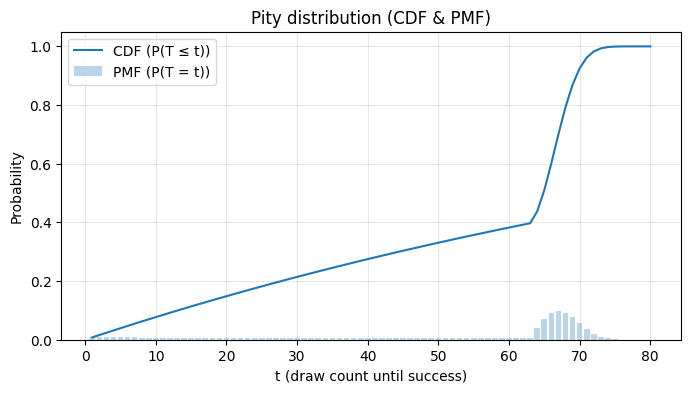

In [ ]:
# === 멀티프로세싱 병렬 시뮬레이터 추가 ===
# 근데 느림. 뭐지?

import os
from multiprocessing import Pool, cpu_count

def _worker_chunk(args):
    (chunk_size, goal, cdf, p_coin, obs_total, bins, seed) = args
    rng = np.random.default_rng(seed)

    # 1) 각 시뮬레이션별 episode 수 결정: 7 + Binomial(7, p)
    add_eps = rng.binomial(n=7, p=p_coin, size=chunk_size).astype(np.int16)
    eps_each = goal + add_eps   # [7..14]
    max_ep = goal * 2           # 14

    # 2) 역 CDF 샘플링 (float64 권장: 미세 톱니 완화)
    U = rng.random((chunk_size, max_ep))
    T = np.searchsorted(cdf, U, side="left") + 1

    # 3) 가변 길이 합(마스킹)
    mask = (np.arange(max_ep, dtype=np.int16)[None, :] < eps_each[:, None])
    totals = (T * mask).sum(axis=1, dtype=np.int64)

    # 4) 청크 요약값만 반환(메모리/IPC 최소화)
    le_cnt = int((totals <= obs_total).sum())
    s1 = int(totals.sum())
    s2 = int((totals.astype(np.int64) ** 2).sum())
    mn = int(totals.min())
    mx = int(totals.max())

    # bins: int 또는 array-like 모두 허용
    hist_counts, hist_edges = np.histogram(totals, bins=bins, density=False)
    return (le_cnt, s1, s2, mn, mx, hist_counts, hist_edges)

def simulate_and_summarize_mp(n_sims=N_SIMS, goal=GOAL, obs_total=OBS_TOTAL, seed=SEED,
                              bins=BINS, n_workers=None, chunk_size=1_000_000,
                              plot_hist=True, set_single_thread_blas=True):
    """
    멀티프로세싱 버전. totals 전체 배열을 보관하지 않고,
    청크별 요약값과 히스토그램만 합산하여 통계를 산출합니다.
    """
    # BLAS 과다 스레딩 방지(프로세스 병렬에 자원 집중)
    if set_single_thread_blas:
        os.environ.setdefault("OMP_NUM_THREADS", "1")
        os.environ.setdefault("MKL_NUM_THREADS", "1")
        os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")

    if n_workers is None:
        n_workers = cpu_count() // 2

    cdf = build_pity_cdf()

    # 작업 청크 나누기
    tasks = []
    sims_left = n_sims
    stream_seed = seed
    while sims_left > 0:
        cs = min(chunk_size, sims_left)
        tasks.append((cs, goal, cdf, CEIL_RATIO, obs_total, bins, stream_seed))
        sims_left -= cs
        stream_seed += 1

    # 병렬 실행
    with Pool(processes=n_workers) as pool:
        results = pool.map(_worker_chunk, tasks)

    # 집계
    total_sims = 0
    le_total = 0
    sum1 = 0
    sum2 = 0
    gmin, gmax = 10**18, -10**18

    # bins가 int였을 경우, 첫 결과의 edges를 기준으로 사용
    # (np.histogram은 동일 bins(int)면 동일 edges를 돌려줌)
    first_edges = results[0][6]
    global_hist = np.zeros_like(results[0][5], dtype=np.int64)

    for (le_cnt, s1, s2, mn, mx, h, edges) in results:
        total_sims += int(h.sum())
        le_total += le_cnt
        sum1 += s1
        sum2 += s2
        gmin = min(gmin, mn)
        gmax = max(gmax, mx)
        global_hist += h

    mean = sum1 / total_sims
    var = (sum2 / total_sims) - (mean ** 2)
    std = float(np.sqrt(max(var, 0.0)))
    percentile = 100.0 * le_total / total_sims

    # 히스토그램 누적으로 중앙값 근사
    cumsum = np.cumsum(global_hist)
    half = (total_sims + 1) // 2
    median_bin_idx = int(np.searchsorted(cumsum, half, side="left"))
    # bin 중앙값(근사)
    be = first_edges
    median_approx = float((be[median_bin_idx] + be[median_bin_idx + 1]) / 2)

    summary = {
        "samples": int(total_sims),
        "obs_total_draws": int(obs_total),
        "mean_total_draws": float(mean),
        "median_total_draws_approx": float(median_approx),
        "std_total_draws": float(std),
        "percentile_rank_of_obs_%": float(percentile),
        "min_total_draws": int(gmin),
        "max_total_draws": int(gmax),
        "n_workers": int(n_workers),
        "chunk_size": int(chunk_size),
    }

    # 플롯(밀도 스케일)
    if plot_hist:
        # density=True로 보이게 하려면 bin 폭으로 나눠 정규화
        widths = np.diff(be)
        density = global_hist / (global_hist.sum() * widths)
        centers = (be[:-1] + be[1:]) / 2
        plt.figure()
        plt.bar(centers, density, width=widths, align="center")
        plt.axvline(obs_total, linestyle="--")
        plt.title(f"Total draws distribution (MP) : GET {goal}  | #sim: {total_sims:,}")
        plt.xlabel("Total draws across episodes")
        plt.ylabel("Density")
        plt.show()

    return summary, (global_hist, first_edges)


if __name__ == "__main__":
    # 원래 단일 프로세스 버전
    # totals, summary = simulate_and_summarize(...)

    # 멀티프로세싱 버전 (권장)
    summary_mp, (hist_counts, bin_edges) = simulate_and_summarize_mp(
        n_sims=N_SIMS,
        goal=GOAL,
        obs_total=OBS_TOTAL,
        seed=SEED,
        bins=BINS,          # int 또는 직접 경계 배열 모두 가능
        n_workers=None,     # 기본: 모든 코어
        chunk_size=1_000_000,
        plot_hist=True
    )
    print(pd.DataFrame([summary_mp]).round(3).to_string(index=False))


In [ ]:
# -*- coding: utf-8 -*-
import random
from bisect import bisect_left
from math import isfinite
from typing import Dict, Tuple, List

# ---- GAME_ID별 기본 파라미터 ----
GAME_TABLE = {
    1: dict(CEIL_RATIO=0.5,  MAX_T=80, BASE_P=0.008, ACCEL_START=63, ACCEL_STEP=0.06),
    2: dict(CEIL_RATIO=0.55, MAX_T=90, BASE_P=0.006, ACCEL_START=73, ACCEL_STEP=0.06),
}

# ----- fitting ------
from math import sqrt, pi, exp

def _mean(xs):  # 기존 정의 있어도 동일
    return (sum(xs) / len(xs)) if xs else float("nan")

def _std_mle(xs):  # MLE 표준편차(ddof=0) – 정규 최우추정치
    n = len(xs)
    if n <= 1:
        return 0.0
    mu = _mean(xs)
    var = sum((x - mu) ** 2 for x in xs) / n
    return var ** 0.5

def _std_ddof1(xs):  # 이미 있으시면 이건 유지
    n = len(xs)
    if n <= 1:
        return 0.0
    mu = _mean(xs)
    var = sum((x - mu) ** 2 for x in xs) / (n - 1)
    return var ** 0.5

def _normal_pdf(x, mu, sigma):
    if sigma <= 0:
        return 0.0
    z = (x - mu) / sigma
    return (1.0 / (sigma * sqrt(2.0 * pi))) * exp(-0.5 * z * z)

def _ecdf(xs_sorted, x):
    # 간단한 ECDF: P(X ≤ x)
    # xs_sorted는 사전 정렬 리스트
    lo, hi = 0, len(xs_sorted)
    while lo < hi:
        mid = (lo + hi) // 2
        if xs_sorted[mid] <= x:
            lo = mid + 1
        else:
            hi = mid
    return lo / len(xs_sorted)

def _ks_distance_to_normal(xs, mu, sigma, grid=200):
    # Kolmogorov–Smirnov D (간이): 균등 격자에서 sup|F_n - Φ|
    if not xs or sigma <= 0:
        return 1.0
    ys = sorted(xs)
    xmin, xmax = ys[0], ys[-1]
    if xmax == xmin:  # 단일값 보호
        xmax += 1.0
        xmin -= 1.0
    # 표준 정규 CDF 근사(에러펑션 없이 폴딩 근사): 빠른 Remez 계열 근사 사용
    # Hastings(1955) 근사에 기반한 간략 버전
    def phi(z):
        # Φ(z)
        t = 1.0 / (1.0 + 0.2316419 * abs(z))
        b = ((((1.330274429 * t - 1.821255978) * t + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
        nd = (1.0 / sqrt(2.0 * pi)) * exp(-0.5 * z * z)
        val = 1.0 - nd * b
        return val if z >= 0 else 1.0 - val

    D = 0.0
    for i in range(grid + 1):
        x = xmin + (xmax - xmin) * i / grid
        Fn = _ecdf(ys, x)
        z = (x - mu) / sigma
        F = phi(z)
        d = abs(Fn - F)
        if d > D: D = d
    return D

def make_hist_svg_with_normal(totals, obs_total, bins=128, title="", fit=True):
    if not totals:
        return '<svg xmlns="http://www.w3.org/2000/svg" width="800" height="450"></svg>'

    # 히스토그램(density)
    x_min, x_max = min(totals), max(totals)
    if x_max == x_min:
        x_min -= 0.5; x_max += 0.5
    bins = max(32, min(int(bins), 256))
    width = (x_max - x_min) / float(bins)
    edges = [x_min + i * width for i in range(bins + 1)]
    counts = [0] * bins
    for v in totals:
        i = int((v - x_min) / width)
        if i == bins: i -= 1
        counts[i] += 1
    n = len(totals)
    density = [c / (n * width) for c in counts]

    # 정규 적합
    mu = _mean(totals)
    sigma_mle = _std_mle(totals)
    # 표시용 표준편차(표본 표준편차)도 계산해 summary에 같이 넣을 수 있게
    sigma_ddof1 = _std_ddof1(totals)

    # SVG 좌표
    W, H = 800, 450
    L, R, T, B = 60, 20, 30, 50
    innerW, innerH = W - L - R, H - T - B

    # 정규 PDF 샘플 (곡선)
    xs = []
    pdf = []
    if fit and sigma_mle > 0:
        pts = max(120, min(480, bins * 2))  # 매끄러운 곡선용 포인트
        for i in range(pts + 1):
            x = x_min + (x_max - x_min) * i / pts
            xs.append(x)
            pdf.append(_normal_pdf(x, mu, sigma_mle))

    # y 스케일(히스토 density와 정규 pdf를 같은 축에)
    y_max = max(max(density) if density else 1.0, max(pdf) if pdf else 0.0, 1e-6)

    def sx(x): return L + (x - x_min) * (innerW / max(1e-9, (x_max - x_min)))
    def sy(y): return T + innerH - y * (innerH / y_max)

    # 히스토 – 단일 path(면적; 기존보다 더 얇게)
    path_cmds = []
    x0 = edges[0]
    y0 = 0.0
    path_cmds.append(f"M {sx(x0):.2f} {sy(y0):.2f}")
    for i, d in enumerate(density):
        x1 = edges[i+1]
        if d < (y_max * 1e-5): d = 0.0
        path_cmds.append(f"L {sx(x1):.2f} {sy(y0):.2f}")
        path_cmds.append(f"L {sx(x1):.2f} {sy(d):.2f}")
        y0 = d
    path_cmds.append(f"L {sx(edges[-1]):.2f} {sy(0):.2f} Z")
    area_path = " ".join(path_cmds)

    # 정규 곡선 path
    curve = ""
    if pdf:
        parts = [f"M {sx(xs[0]):.2f} {sy(pdf[0]):.2f}"]
        for x, y in zip(xs[1:], pdf[1:]):
            parts.append(f"L {sx(x):.2f} {sy(y):.2f}")
        curve = f'<path d="{" ".join(parts)}" fill="none" stroke="#0d47a1" stroke-width="2.2"/>'

    # 관측치 수직선
    ox = sx(min(max(obs_total, x_min), x_max))
    obs_line = f'<line x1="{ox:.2f}" y1="{T}" x2="{ox:.2f}" y2="{T+innerH}" stroke="#c62828" stroke-dasharray="6 4" stroke-width="2"/>'

    # 축/레이블
    axes = [
        f'<line x1="{L}" y1="{T+innerH}" x2="{L+innerW}" y2="{T+innerH}" stroke="black"/>',
        f'<line x1="{L}" y1="{T}" x2="{L}" y2="{T+innerH}" stroke="black"/>',
        f'<text x="{L+innerW/2:.2f}" y="{H-8}" text-anchor="middle" font-size="12">Total draws</text>',
        f'<text x="16" y="{T+innerH/2:.2f}" transform="rotate(-90 16,{T+innerH/2:.2f})" font-size="12">Density</text>',
        f'<text x="{W/2:.2f}" y="20" text-anchor="middle" font-size="16">{title}</text>',
    ]
    ticks = []
    for i in range(6):
        vx = x_min + (x_max - x_min) * i / 5.0
        tx = sx(vx)
        ticks.append(f'<line x1="{tx:.2f}" y1="{T+innerH}" x2="{tx:.2f}" y2="{T+innerH+6}" stroke="black"/>')
        ticks.append(f'<text x="{tx:.2f}" y="{T+innerH+22}" text-anchor="middle" font-size="11">{int(round(vx))}</text>')

    legend = (
        f'<rect x="{W-280}" y="{T+8}" width="260" height="54" rx="8" fill="white" opacity="0.85" />'
        f'<circle cx="{W-260}" cy="{T+26}" r="5" fill="black" opacity="0.25"/><text x="{W-246}" y="{T+30}" font-size="12">Histogram (density)</text>'
        f'<line x1="{W-265}" y1="{T+44}" x2="{W-255}" y2="{T+44}" stroke="#0d47a1" stroke-width="2.2"/><text x="{W-246}" y="{T+48}" font-size="12">Normal fit PDF</text>'
    )

    svg = f'''<svg xmlns="http://www.w3.org/2000/svg" width="{W}" height="{H}">
  <rect x="0" y="0" width="{W}" height="{H}" fill="white"/>
  {''.join(axes)}
  <path d="{area_path}" fill="black" opacity="0.14" stroke="none"/>
  {curve}
  {obs_line}
  {''.join(ticks)}
  {legend}
</svg>'''
    return svg, mu, sigma_mle, sigma_ddof1




# ---------- CDF 구성 ----------
def build_pity_cdf(max_t: int, base_p: float, accel_start: int, accel_step: float) -> List[float]:
    """최초 성공까지 걸리는 시도수 T(1..max_t)의 CDF (list[float])"""
    # p[t-1] = 각 시도에서의 성공 확률
    p = [0.0] * max_t
    for t in range(1, max_t + 1):
        if t <= accel_start:
            p[t-1] = base_p
        else:
            inc = base_p + accel_step * (t - accel_start)
            p[t-1] = inc if inc < 1.0 else 1.0

    pmf = [0.0] * max_t
    survival = 1.0
    for i in range(max_t):
        pmf[i] = survival * p[i]
        survival *= (1.0 - p[i])

    cdf = [0.0] * max_t
    s = 0.0
    for i in range(max_t):
        s += pmf[i]
        cdf[i] = s

    # 꼬리 보정
    tail = 1.0 - cdf[-1]
    if tail > 0:
        pmf[-1] += tail
        s = 0.0
        for i in range(max_t):
            s += pmf[i]
            cdf[i] = s
    return cdf

# ---------- 난수/샘플 ----------
def _sample_T_from_cdf(cdf: List[float]) -> int:
    """cdf를 이용해 1..len(cdf) 범위의 T를 샘플링"""
    u = random.random()
    idx = bisect_left(cdf, u)
    return idx + 1  # 1-based 시도 횟수

def _binomial_7(p: float) -> int:
    """n=7, p의 이항 샘플(순수 파이썬)"""
    cnt = 0
    for _ in range(7):
        if random.random() < p:
            cnt += 1
    return cnt

def sample_total_draws(n_sims: int, base_episodes: int, cdf: List[float], ceil_ratio: float, seed: int) -> List[int]:
    """에피소드 수가 동적으로 늘어나는 구조를 반영해 각 시뮬레이션 총 뽑기수 리스트 반환."""
    random.seed(seed)
    totals: List[int] = [0] * n_sims
    for i in range(n_sims):
        add_ep = _binomial_7(ceil_ratio)   # 7번의 50% 시도 중 성공 수
        k = base_episodes + add_ep         # 실제 episode 수
        s = 0
        for _ in range(k):
            s += _sample_T_from_cdf(cdf)
        totals[i] = s
    return totals

# ---------- 요약 ----------
def _mean(xs: List[int]) -> float:
    return (sum(xs) / len(xs)) if xs else float("nan")

def _median(xs: List[int]) -> float:
    n = len(xs)
    if n == 0:
        return float("nan")
    ys = sorted(xs)
    mid = n // 2
    if n % 2 == 1:
        return float(ys[mid])
    return (ys[mid - 1] + ys[mid]) / 2.0

def _std_ddof1(xs: List[int]) -> float:
    n = len(xs)
    if n <= 1:
        return 0.0
    mu = _mean(xs)
    var = sum((x - mu) ** 2 for x in xs) / (n - 1)
    return var ** 0.5

def summarize(totals: List[int], obs_total: int, n_sims: int) -> Dict:
    greater = sum(1 for x in totals if x > obs_total)
    percentile = (greater / len(totals) * 100.0) if totals else float("nan")
    return {
        "samples": int(n_sims),
        "obs_total_draws": int(obs_total),
        "mean_total_draws": float(_mean(totals)),
        "median_total_draws": float(_median(totals)),
        "std_total_draws": float(_std_ddof1(totals)),
        "percentile_rank_of_obs_%": float(percentile),
    }


# ---------- 파이프라인 ----------
def run_simulation(
    game_id: int,
    goal: int,
    obs_total: int,
    n_sims: int = 100_000,   # 순수 파이썬이라 기본값을 낮춤(필요시 조정)
    seed: int = 20251014,
    bins: int = 890,
) -> Tuple[Dict, str]:
    cfg = GAME_TABLE.get(game_id)
    if not cfg:
        raise ValueError(f"Unknown GAME_ID: {game_id}")

    cdf = build_pity_cdf(
        max_t=cfg["MAX_T"],
        base_p=cfg["BASE_P"],
        accel_start=cfg["ACCEL_START"],
        accel_step=cfg["ACCEL_STEP"],
    )
    totals = sample_total_draws(
        n_sims=n_sims,
        base_episodes=goal,
        cdf=cdf,
        ceil_ratio=cfg["CEIL_RATIO"],
        seed=seed,
    )
    summary = summarize(totals, obs_total, n_sims)
    title = f"Total draws distribution: GET {goal} (n={n_sims})"
    svg, mu, sigma_mle, sigma_ddof1 = make_hist_svg_with_normal(
        totals, obs_total, bins=bins, title=title, fit=True
    )
    # 간단 KS 거리(정규 적합 적합도 척도)
    ks = _ks_distance_to_normal(totals, mu, sigma_mle)
    summary.update({
        "normal_fit_mu": float(mu),
        "normal_fit_sigma_mle": float(sigma_mle),
        "normal_fit_sigma_sample": float(sigma_ddof1),
        "ks_distance": float(ks),
    })
    return summary, svg


In [22]:
run_simulation(1, 7, 888)

({'samples': 100000,
  'obs_total_draws': 888,
  'mean_total_draws': 551.01502,
  'median_total_draws': 550.0,
  'std_total_draws': 99.72731456212134,
  'percentile_rank_of_obs_%': 0.023,
  'normal_fit_mu': 551.01502,
  'normal_fit_sigma_mle': 99.72681592430193,
  'normal_fit_sigma_sample': 99.72731456212134,
  'ks_distance': 0.005809461451816933},
 '<svg xmlns="http://www.w3.org/2000/svg" width="800" height="450">\n  <rect x="0" y="0" width="800" height="450" fill="white"/>\n  <line x1="60" y1="400" x2="780" y2="400" stroke="black"/><line x1="60" y1="30" x2="60" y2="400" stroke="black"/><text x="420.00" y="442" text-anchor="middle" font-size="12">Total draws</text><text x="16" y="215.00" transform="rotate(-90 16,215.00)" font-size="12">Density</text><text x="400.00" y="20" text-anchor="middle" font-size="16">Total draws distribution: GET 7 (n=100000)</text>\n  <path d="M 60.00 400.00 L 62.81 400.00 L 62.81 399.52 L 65.62 399.52 L 65.62 399.76 L 68.44 399.76 L 68.44 400.00 L 71.25 400.

In [2]:
draws = [65, 68, 65, 69, 65, 70, 62, 49, 47, 58, 69, 63, 69, 69]
print(sum(draws))

888


In [ ]:
# -*- coding: utf-8 -*-
import random
from bisect import bisect_left
from math import isfinite
from typing import Dict, Tuple, List

# ---- GAME_ID별 기본 파라미터 ----
GAME_TABLE = {
    1: dict(CEIL_RATIO=0.5,  MAX_T=80, BASE_P=0.008, ACCEL_START=63, ACCEL_STEP=0.06),
    2: dict(CEIL_RATIO=0.55, MAX_T=90, BASE_P=0.006, ACCEL_START=73, ACCEL_STEP=0.06),
}

N_SIMS = 100_000  # 메모리 부담 감소 (100k → 50k)
SEED = 31014646
BINS = 300


# ----- 최소한의 통계 함수만 유지 ------
from math import sqrt

def make_hist_svg(totals, obs_total, bins=128, title=""):
    """히스토그램 SVG 생성 (정규분포 제거)

    Args:
        totals: 시뮬레이션 데이터 리스트
        obs_total: 관측된 값 (빨간 수직선 표시)
        bins: 히스토그램 구간 수
        title: 차트 제목

    Returns:
        svg_string
    """
    if not totals:
        return '<svg xmlns="http://www.w3.org/2000/svg" width="800" height="450"></svg>'

    # 히스토그램(density)
    x_min, x_max = min(totals), max(totals)
    if x_max == x_min:
        x_min -= 0.5; x_max += 0.5
    bins = max(32, min(int(bins), 256))
    width = (x_max - x_min) / float(bins)
    edges = [x_min + i * width for i in range(bins + 1)]
    counts = [0] * bins
    for v in totals:
        i = int((v - x_min) / width)
        if i == bins: i -= 1
        counts[i] += 1
    n = len(totals)
    density = [c / (n * width) for c in counts]

    # SVG 좌표
    W, H = 800, 450
    L, R, T, B = 60, 20, 30, 50
    innerW, innerH = W - L - R, H - T - B

    # y 스케일
    y_max = max(density) if density else 1.0

    def sx(x): return L + (x - x_min) * (innerW / max(1e-9, (x_max - x_min)))
    def sy(y): return T + innerH - y * (innerH / y_max)

    # 히스토그램 path
    y0 = 0.0
    threshold = y_max * 1e-5
    path_parts = [f"M {sx(edges[0]):.2f} {sy(0.0):.2f}"]
    for i, d in enumerate(density):
        x1 = edges[i+1]
        d_val = 0.0 if d < threshold else d
        path_parts.extend([f"L {sx(x1):.2f} {sy(y0):.2f}", f"L {sx(x1):.2f} {sy(d_val):.2f}"])
        y0 = d_val
    path_parts.append(f"L {sx(edges[-1]):.2f} {sy(0):.2f} Z")
    area_path = " ".join(path_parts)

    # 관측치 수직선
    ox = sx(min(max(obs_total, x_min), x_max))
    obs_line = f'<line x1="{ox:.2f}" y1="{T}" x2="{ox:.2f}" y2="{T+innerH}" stroke="#c62828" stroke-dasharray="6 4" stroke-width="2"/>'

    # 축/레이블
    mid_w, mid_h = L + innerW / 2, T + innerH / 2
    bottom_y = T + innerH
    axes = [
        f'<line x1="{L}" y1="{bottom_y}" x2="{L+innerW}" y2="{bottom_y}" stroke="black"/>',
        f'<line x1="{L}" y1="{T}" x2="{L}" y2="{bottom_y}" stroke="black"/>',
        f'<text x="{mid_w:.2f}" y="{H-8}" text-anchor="middle" font-size="12">Total draws</text>',
        f'<text x="16" y="{mid_h:.2f}" transform="rotate(-90 16,{mid_h:.2f})" font-size="12">Density</text>',
        f'<text x="{W/2:.2f}" y="20" text-anchor="middle" font-size="16">{title}</text>',
    ]

    # ticks
    x_range = x_max - x_min
    tick_y1, tick_y2 = bottom_y, bottom_y + 6
    ticks = []
    for i in range(6):
        vx = x_min + x_range * i / 5.0
        tx = sx(vx)
        ticks.extend([
            f'<line x1="{tx:.2f}" y1="{tick_y1}" x2="{tx:.2f}" y2="{tick_y2}" stroke="black"/>',
            f'<text x="{tx:.2f}" y="{tick_y2+16}" text-anchor="middle" font-size="11">{int(round(vx))}</text>'
        ])

    svg = f'''<svg xmlns="http://www.w3.org/2000/svg" width="{W}" height="{H}">
  <rect x="0" y="0" width="{W}" height="{H}" fill="white"/>
  {''.join(axes)}
  <path d="{area_path}" fill="black" opacity="0.14" stroke="none"/>
  {obs_line}
  {''.join(ticks)}
</svg>'''
    return svg




# ---------- CDF 구성 ----------
def build_pity_cdf(game_id) -> List[float]:
    """최초 성공까지 걸리는 시도수 T(1..max_t)의 CDF (list[float])"""
    cfg = GAME_TABLE.get(game_id)
    max_t = cfg["MAX_T"]
    base_p = cfg["BASE_P"]
    accel_start = cfg["ACCEL_START"]
    accel_step = cfg["ACCEL_STEP"]

    # p[t-1] = 각 시도에서의 성공 확률
    p = [0.0] * max_t
    for t in range(1, max_t + 1):
        if t <= accel_start:
            p[t-1] = base_p
        else:
            inc = base_p + accel_step * (t - accel_start)
            p[t-1] = inc if inc < 1.0 else 1.0

    pmf = [0.0] * max_t
    survival = 1.0
    for i in range(max_t):
        pmf[i] = survival * p[i]
        survival *= (1.0 - p[i])

    cdf = [0.0] * max_t
    s = 0.0
    for i in range(max_t):
        s += pmf[i]
        cdf[i] = s

    # 꼬리 보정
    tail = 1.0 - cdf[-1]
    if tail > 0:
        pmf[-1] += tail
        s = 0.0
        for i in range(max_t):
            s += pmf[i]
            cdf[i] = s
    return cdf

# ---------- 난수/샘플 ----------

def _build_alias_from_cdf(cdf: List[float]) -> Tuple[List[float], List[int]]:
    """Walker's Alias Method를 위한 전처리 테이블 생성

    CDF에서 PMF를 추출하고 O(1) 샘플링을 위한 alias 테이블 구성

    Args:
        cdf: 누적분포함수 (정규화되지 않아도 됨)

    Returns:
        (prob, alias): Alias Method용 확률 테이블과 별칭 테이블
    """
    # 리스트 컴프리헨션으로 PMF 추출 (최적화)
    M = len(cdf)
    pmf = [cdf[0]] + [cdf[i] - cdf[i-1] for i in range(1, M)]
    s = sum(pmf)
    if s <= 0:
        raise ValueError("Invalid CDF: sum must be positive")

    # 정규화 및 스케일링을 한 번에 처리
    scaled = [p * M / s for p in pmf]

    # 초기 분류
    small = [i for i, v in enumerate(scaled) if v < 1.0]
    large = [i for i, v in enumerate(scaled) if v >= 1.0]

    prob = [0.0] * M
    alias = [0] * M

    while small and large:
        s_i = small.pop()
        l_i = large.pop()
        prob[s_i] = scaled[s_i]
        alias[s_i] = l_i
        scaled[l_i] = scaled[l_i] + scaled[s_i] - 1.0
        (small if scaled[l_i] < 1.0 else large).append(l_i)

    for i in large + small:
        prob[i] = 1.0
    return prob, alias

def _alias_sample(prob: List[float], alias: List[int]) -> int:
    """Alias Method를 이용한 O(1) 샘플링

    Returns:
        1부터 len(prob)까지의 정수 (1-indexed)
    """
    i = int(random.random() * len(prob))
    return (i + 1) if random.random() < prob[i] else (alias[i] + 1)

def _binomial_7(p: float) -> int:
    """이항분포 B(7, p) 샘플링

    Args:
        p: 성공 확률

    Returns:
        0~7 사이의 성공 횟수
    """
    c = 0
    for _ in range(7):
        if random.random() < p:
            c += 1
    return c

def sample_total_draws(n_sims: int, base_episodes: int,
                       cdf: List[float], ceil_ratio: float, seed: int) -> List[int]:
    """몬테카를로 시뮬레이션: 총 뽑기 횟수 분포 생성

    Args:
        n_sims: 시뮬레이션 반복 횟수
        base_episodes: 기본 에피소드 수
        cdf: 단일 에피소드의 CDF
        ceil_ratio: 추가 에피소드 발생 확률
        seed: 난수 시드

    Returns:
        각 시뮬레이션의 총 뽑기 횟수 리스트
    """
    # 난수 생성기 초기화 (전역 상태 사용)
    random.seed(seed)

    # Alias 테이블 전처리
    prob, alias = _build_alias_from_cdf(cdf)

    # 로컬 변수로 함수 참조 캐싱 (속도 향상)
    _rand = random.random
    M = len(prob)

    totals: List[int] = [0] * n_sims
    for i in range(n_sims):
        # 이항분포 인라인 (함수 호출 오버헤드 제거)
        add_ep = sum(1 for _ in range(7) if _rand() < ceil_ratio)
        k = base_episodes + add_ep

        # Alias 샘플링 인라인 (최적화)
        s = 0
        for _ in range(k):
            idx = int(_rand() * M)
            s += (idx + 1) if _rand() < prob[idx] else (alias[idx] + 1)
        totals[i] = s

    return totals

# ---------- 요약 ----------
def summarize(totals: List[int], obs_total: int, n_sims: int) -> Dict:
    """시뮬레이션 결과 통계 요약

    Args:
        totals: 시뮬레이션 데이터 리스트
        obs_total: 관측된 총 뽑기 횟수
        n_sims: 시뮬레이션 횟수

    Returns:
        통계 요약 딕셔너리
    """
    n = len(totals)
    if n == 0:
        return {
            "samples": int(n_sims),
            "obs_total_draws": int(obs_total),
            "mean_total_draws": float("nan"),
            "std_total_draws": float("nan"),
            "percentile_rank_of_obs_%": float("nan"),
        }

    # 한 번의 순회로 평균과 percentile 계산 (O(n))
    total_sum = 0
    greater = 0
    for x in totals:
        total_sum += x
        if x > obs_total:
            greater += 1

    mean = total_sum / n

    # 두 번째 순회로 분산 계산 (O(n))
    var_sum = 0.0
    for x in totals:
        var_sum += (x - mean) ** 2

    std = (var_sum / (n - 1)) ** 0.5 if n > 1 else 0.0
    percentile = (greater / n) * 100.0

    return {
        "samples": int(n_sims),
        "obs_total_draws": int(obs_total),
        "mean_total_draws": float(mean),
        "std_total_draws": float(std),
        "percentile_rank_of_obs_%": float(percentile),
    }


# ---------- 파이프라인 ----------
def run_simulation(
    game_id: int,
    goal: int,
    obs_total: int,
    n_sims: int = N_SIMS,
    seed: int = None,  # None이면 자동 생성
    bins: int = BINS,
    cdf: dict = {}
) -> Tuple[Dict, str]:
    """시뮬레이션 실행 및 통계 분석

    Args:
        game_id: 게임 ID (1 또는 2)
        goal: 목표 획득 수
        obs_total: 관측된 총 뽑기 횟수
        n_sims: 시뮬레이션 횟수
        seed: 난수 시드 (None이면 시간 기반 자동 생성)
        bins: 히스토그램 bins (실제로는 내부에서 재계산됨)
        cdf: 사전 계산된 CDF (선택적)

    Returns:
        (summary_dict, svg_string): 통계 요약과 SVG 히스토그램

    Raises:
        ValueError: 잘못된 입력값
    """
    # 입력 검증
    cfg = GAME_TABLE.get(int(game_id))
    if not cfg:
        raise ValueError(f"Unknown GAME_ID: {game_id}")

    # seed가 None이면 각 호출마다 다른 시드 생성
    if seed is None:
        import time
        seed = (int(time.time() * 1000000) ^ hash((game_id, goal, obs_total))) % (2**31)

    if not cdf:
        cdf = build_pity_cdf(game_id)
    
    totals = sample_total_draws(
        n_sims=n_sims,
        base_episodes=goal,
        cdf=cdf,
        ceil_ratio=cfg["CEIL_RATIO"],
        seed=seed,
    )
    # bins 계산: goal에 비례한 히스토그램 해상도 설정
    # 공식: goal * 160 / 3 (goal이 클수록 더 세밀한 bins)
    bins = (goal * 155) // 3

    summary = summarize(totals, obs_total, n_sims)
    title = f"Total draws distribution: GET {goal} (n={n_sims})"
    svg = make_hist_svg(totals, obs_total, bins=bins, title=title)

    # 명시적으로 totals 참조 해제 (메모리 절약)
    del totals

    return summary, svg
